# Diffusion of Mg in plagioclase: A Finite Difference Method Approach
*Jordan Lubbers* <br>
*Alaska Volcano Observatory U.S. Geological Survey* <br>

Last updated 6/6/2024

Utilizes the forward difference scheme to the finite difference method for Fick's $2^{nd}$ Law outlined [here](https://github.com/jlubbersgeo/diffusion_chronometry/blob/main/plag_diffusion_model_github.ipynb)




## Dependencies

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

from tqdm.notebook import tqdm

import glob as glob
from PIL import Image

import plag_diff as plag

# default plotting style
# this is custom so just omit or make your own
# mplstyle file!
plt.style.use('jubb')

export_path = export_path = r".\test_outputs"



## Import data

Enter the paths for your trace element data spreadsheet and to the folder that holds BSE images (optional).

NOTE THIS ASSUMES YOU ARE GOING FROM CORE --> RIM (LEFT TO RIGHT). MAKE SURE YOUR OWN DATA ARE ORGANIZED THIS WAY.

In [2]:
# path to where data is stored
data = pd.read_excel(r".\test_data\plag_diffusion_test_data.xlsx")
data = data.set_index("grain")

#path to folder where images are
image_folder_path = (r".\test_data")
image_files = glob.glob(f"{image_folder_path}/*.tif")

print(data.index.unique().tolist())

['ns8_1-1']


Text(0.5, 0, 'Distance ($\\mu$m)')

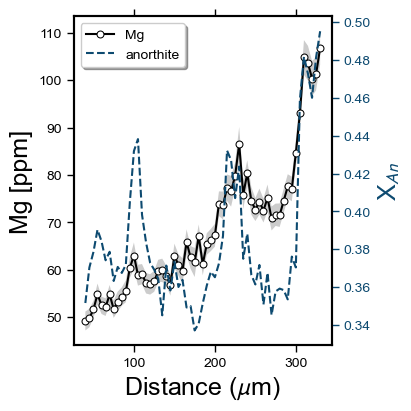

In [3]:
# specify which grain to use
grain = "ns8_1-1"

# specify which element to model
element = "Mg"

resolution = 5.0  # um

# for consistent colors throughout
obs_color = "#000000"  # observed data
# equilibrium data
bindeman_color =  "#FF1F5B"  
nielsen_color = "#009ADE"
mutch_color =  "#AF58BA" 
dohmen_color = "#F28522"

an_color = "#0D4A70"
init_color = "#A0B1BA"  # initial profile related data
bf_color = "#00CD6C"

models = ["Bindeman","Mutch", "Dohmen"]

# the domain you wish to model diffusion over
# try to keep this untouched but if there are
# erroneous ends on your data this will clip them
start = 8
stop = 0


# unclipped data for a grain
# distance
dist_all = np.arange(0, data.loc[grain, :].shape[0]) * resolution
# measured trace element information
te_all = data.loc[grain, element].to_numpy()
te_unc_all = data.loc[grain, "{}_se".format(element)].to_numpy()
# anorthite
an_all = data.loc[grain, "An"].to_numpy()
if np.unique(an_all>1)[0] == True:
    an_all = an_all / 100
# clipped data. If above start and stop are 0 they
# will be the same as the unclipped data. This is fine.
te = te_all[start : len(te_all) - stop]
te_unc = te_unc_all[start : len(te_all) - stop]
dist = dist_all[start : len(te_all) - stop]
an = an_all[start : len(te_all) - stop]


# plot observed data
fig, ax = plt.subplots(figsize = (4,4))
# observed profile and subset
l1, = ax.plot(
    dist,
    te,
    c=obs_color,
    marker="o",
    mfc="w",
    mec=obs_color,
    ms=5,
    mew=0.75,
    label=element,
)
ax.fill_between(dist, te + te_unc, te - te_unc, fc = obs_color, alpha=0.2)

ax2 = ax.twinx()
l2, = ax2.plot(
    dist,
    an,
    c=an_color,
    marker="",
    mfc="w",
    mec=an_color,
    ms=5,
    mew=0.75,
    ls = '--',
    label="anorthite",
)
ax2.tick_params(axis="y", which="both", colors=an_color)
ax2.set_ylabel("X$_{An}$", c=an_color)

ax.legend(handles = [l1,l2],fancybox = True, shadow = True)
# fig.legend(loc="best")

ax.set_ylabel("{} [ppm]".format(element), c=obs_color)
ax.tick_params(axis="y", which="both", colors=obs_color)
ax.set_xlabel("Distance ($\mu$m)")
# fig.set_facecolor('w')
# plt.savefig('{}\observed_profile_example.pdf'.format(export_path),bbox_inches = 'tight')
# plt.savefig('{}\observed_profile_example.png'.format(export_path),bbox_inches = 'tight')

## Comparing equilibrium profiles across partitioning models

Text(0.0, 1.0, 'Solid')

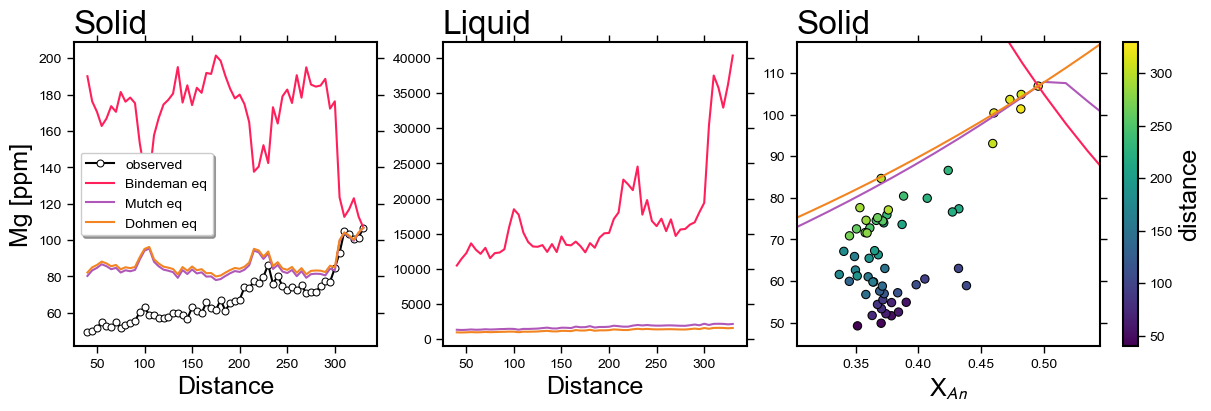

In [4]:
# Thermodynamic parameters
T_K = 1023.15  # K
R = 8.314

sio2_melt = 70 #wt%

# plagioclase partitioning information
# partition coefficient, uncertainty, A, B params
kds = []
rtlnks = []
As = []
Bs = []
cl_rims = []
eq_profs = []
equilibrium_liquids = []

# plotting things up
fig, ax = plt.subplots(1, 3, figsize=(12, 4),layout = 'constrained')
ax[0].plot(
    dist,
    te,
    label="observed",
    c=obs_color,
    marker="o",
    mfc='w',
    mec=obs_color,
    ms=5,
    mew=0.75,
)
# range of anorthite compositions to calculate equilibrium curves
An_partition = np.linspace(0, 1, te.shape[0])
for method,eq_color in zip(models,[bindeman_color,mutch_color,dohmen_color]):
    if method == 'Mutch':
        
        kd, rtlnk, A, x_an_dev = plag.mutch_kd_calc(an,T_K - 273.15, sio2_melt=sio2_melt)
        kd_eq, rtlnk_eq, A_eq, x_an_dev_eq = plag.mutch_kd_calc(An_partition,T_K - 273.15, sio2_melt=sio2_melt)
    else:
        kd, rtlnk, A, B = plag.plag_kd_calc(element, an, T_K - 273.15, method= method,sio2_melt = sio2_melt)
        # Calculated Mg equilibrium
        kd_eq, rtlnk_eq, A_eq, B_eq = plag.plag_kd_calc(
            element, An_partition, T_K-273.15, method=method,sio2_melt = sio2_melt
    )
        
    kds.append(kd)
    rtlnks.append(rtlnk)
    As.append(A)
    # Bs.append(B)



    # concentration of the 'rim-most' equilibrium liquid
    cl_rim = te[-1] / kd[-1]
    cl_rims.append(cl_rim)

    # equilibrium profile based on established equilibrium liquid concentration
    # at the rim
    eq_prof = cl_rim * kd
    eq_profs.append(eq_prof)

    # Assumed equilibrium liquid based on partition coefficients
    # and the observed concentration at each spot
    equilibrium_liquid = te / kd
    equilibrium_liquids.append(equilibrium_liquid)



    
    Eq_solid_ave = cl_rim * kd_eq

    ax[0].plot(
        dist,
        eq_prof,
        marker = '',
        c=eq_color,
        label = f"{method} eq"
    )

    ax[1].plot(
        dist,
        equilibrium_liquid,
        marker = '',
        c=eq_color,
        label = f"{method} eq"
    )
    ax[2].plot(An_partition,Eq_solid_ave,marker = '',color = eq_color)
s = ax[2].scatter(an, te,c = dist,ec = 'k',lw = 0.75,)
fig.colorbar(s,ax = ax[2],label = 'distance')

# ax[0].fill_between(dist,eq_prof + eq_prof_unc, eq_prof - eq_prof_unc,alpha = .2)
ax[0].legend(fancybox=True, shadow=True)
ax[0].set_ylabel("{} [ppm]".format(element))
ax[0].set_xlabel("Distance")
ax[0].set_title("Solid", fontsize=24)


ax[1].set_xlabel("Distance")
ax[1].set_title("Liquid", fontsize=24)

ax[2].set_xlabel("X$_{An}$")
ax[2].set_xlim(0.9*an.min(),1.1*an.max())
ax[2].set_ylim(0.9*te.min(),1.1*te.max())
ax[2].set_title('Solid',fontsize = 24)

# plt.savefig('{}\solid_liquid_profile_example.pdf'.format(export_path),bbox_inches = 'tight')
# plt.savefig('{}\solid_liquid_profile_example.png'.format(export_path),bbox_inches = 'tight')

Text(0, 0.5, 'Mg$^{melt}_{eq}$ [ppm]')

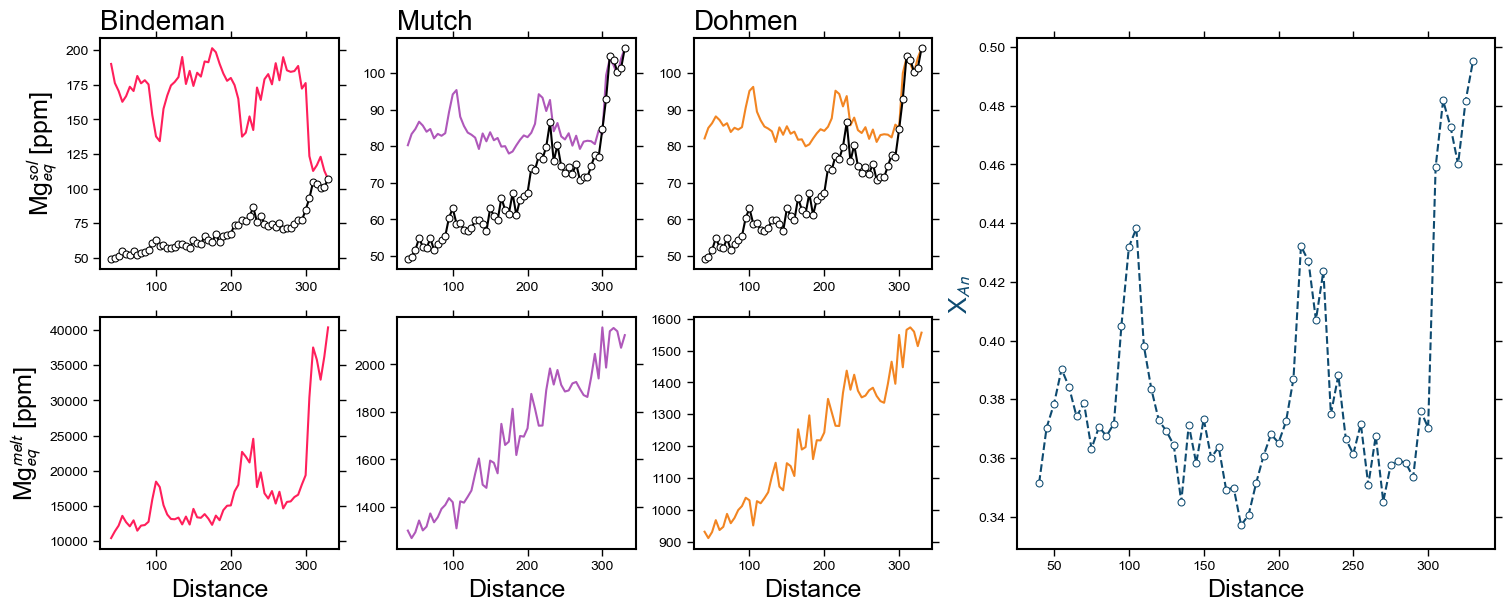

In [5]:
fig,ax = plt.subplots(ncols = 5,nrows = 2,figsize = (15,6),layout = 'constrained')
gs = ax[0,3].get_gridspec()
for a in ax[:,-2:].ravel():
    a.remove()
an_ax = fig.add_subplot(gs[:, -2:])
an_ax.plot(
    dist,
    an,
    c=an_color,
    marker="o",
    mfc="w",
    mec=an_color,
    ms=5,
    mew=0.75,
    ls = '--',
    label="anorthite",
)
an_ax.set_ylabel("X$_{An}$", c=an_color)
an_ax.set_xlabel("Distance")

for liquid,solid, color, name, i in zip(equilibrium_liquids,eq_profs,[bindeman_color,mutch_color,dohmen_color],models,range(ax.shape[1])):
    ax[0,i].set_title(name,fontsize = 20)
    ax[0,i].plot(dist,solid,marker = '',c = color)
    ax[0,i].plot(
    dist,
    te,
    label="observed",
    c=obs_color,
    marker="o",
    mfc='w',
    mec=obs_color,
    ms=5,
    mew=0.75,
)
    
    ax[1,i].plot(dist,liquid, marker = '', c = color)
    ax[1,i].set_xlabel('Distance')

ax[0,0].set_ylabel(f'{element}$^{{sol}}_{{eq}}$ [ppm]')
ax[1,0].set_ylabel(f'{element}$^{{melt}}_{{eq}}$ [ppm]')





## Establish model initial profiles
This is where diffusion will start from!

Text(0.05, 0.65, 't$_{20}$ = 1.89 yrs')

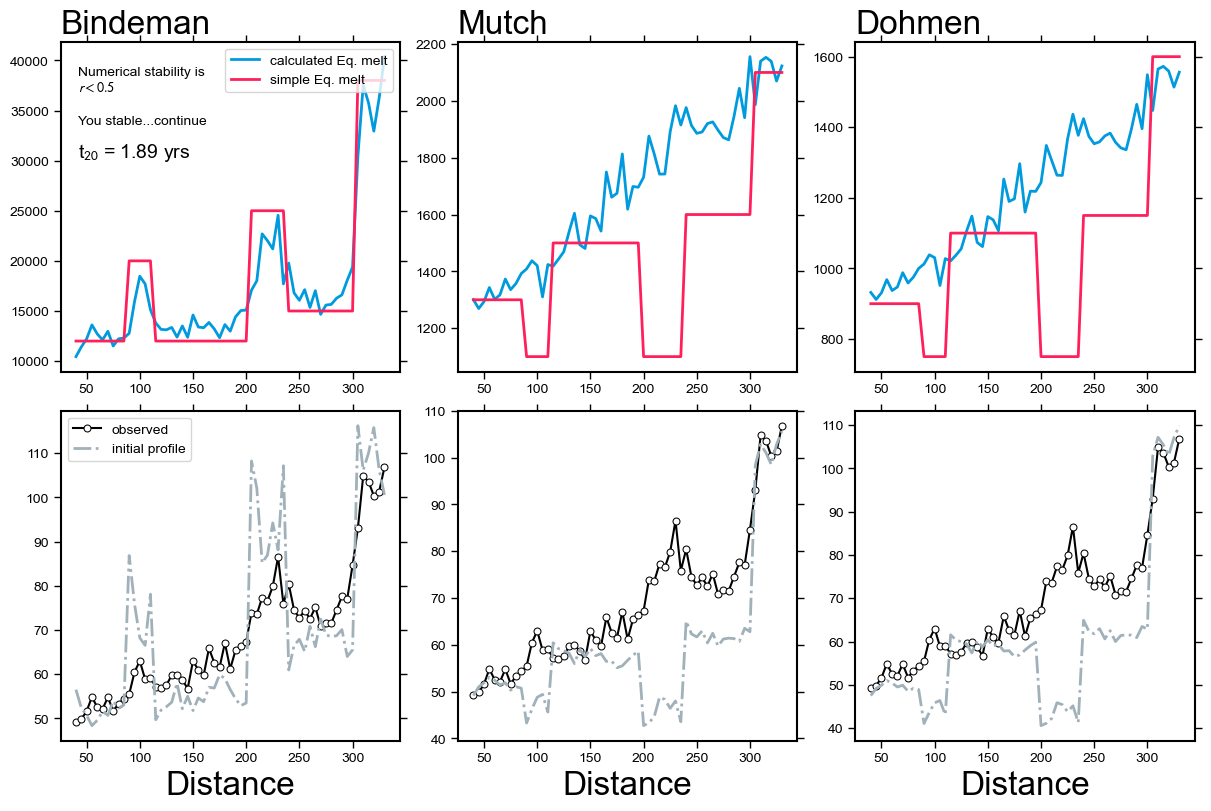

In [6]:

dx = dist[1] - dist[0]

simple_liquid_bindeman = plag.create_stepped_profile(
    dist,
    step_start=[90,205,305],
    step_stop=[115,240,350],
    step_left=[12000,12000,15000],
    step_middle=[20000,25000,38000],
    step_right=[12000,15000,38000],
)

simple_liquid_mutch = plag.create_stepped_profile(
    dist,
    step_start=[90,200,305],
    step_stop=[115,240,350],
    step_left=[1300,1500,1600],
    step_middle=[1100,1100,2100],
    step_right=[1500,1600,2100],
)


simple_liquid_dohmen = plag.create_stepped_profile(
    dist,
    step_start=[90,200,305],
    step_stop=[115,240,350],
    step_left=[900,1100,1150],
    step_middle=[750,750,1600],
    step_right=[1100,1150,1550],
)



initial_profiles = []
fig, ax = plt.subplots(2, 3, figsize=(12, 8), layout="constrained")
axes = ax.ravel()
for a, eq_liq, simple_liq, title in zip(
    axes[:3],
    equilibrium_liquids,
    [simple_liquid_bindeman, simple_liquid_mutch, simple_liquid_dohmen],
    models,
):
    a.plot(dist, eq_liq,marker = '', lw=2, label="calculated Eq. melt")
    a.plot(dist, simple_liq,marker = '', lw=2, label="simple Eq. melt")
    a.set_title(title, fontsize=24)
    if a == axes[0]:
        a.legend(loc="upper right")


for a, simple_liq, k in zip(
    axes[3:], [simple_liquid_bindeman, simple_liquid_mutch, simple_liquid_dohmen], kds
):
    a.plot(
        dist,
        te,
        label="observed",
        c=obs_color,
        marker="o",
        mfc="w",
        mec=obs_color,
        ms=5,
        mew=0.75,
    )
    initial_profile = simple_liq * k
    initial_profiles.append(initial_profile)
    a.plot(dist, initial_profile, init_color,marker = '', ls="-.", lw=2, label="initial profile")
    a.set_xlabel("Distance", fontsize=24)
    if a == axes[3]:
        a.legend(loc="best")

# since our Di is in um^2/s we need to factor that into our time grid
# by spacing out the points accordingly.
# 10,000 years iterating by tenths of year
iterations = int(10 * 1e4)
timestep = "years"

# creating a time grid that is spaced by years
t = plag.get_tgrid(iterations, timestep)

# simple moving average to smooth out the An profile slightly
# Very "spiky" An signals have the potential to create
# errors in the diffusion curve that propagate out of
# control.
an_smooth = np.convolve(an, np.ones(3), "valid") / 3
an_smooth = np.insert(an_smooth, 0, an[0])
an_smooth = np.append(an_smooth, an[-1])


# Van Orman et al 2013 diffusion coefficient
# diffusivity in (um^2/s)
D = plag.plag_diffusivity(element, an, T_K, method="van orman")

# numerical stability value
r = (D * (t[1] - t[0])) / dx**2
if np.any(r > 0.5):
    ax[0, 0].text(
        0.05, 0.75, "YOU DO NOT HAVE NUMERICAL STABILITY", transform=ax[0, 0].transAxes
    )
else:
    ax[0, 0].text(0.05, 0.75, "You stable...continue", transform=ax[0, 0].transAxes)


t20 = (0.24 * (((dist[1] - dist[0]) * 1e-6) ** 2) / (D / 1e12)) / (
    60 * 60 * 24 * 365.25
)

ax[0, 0].text(
    0.05, 0.85, "Numerical stability is\n$r<0.5$", transform=ax[0, 0].transAxes
)
ax[0, 0].text(
    0.05,
    0.65,
    "t$_{{20}}$ = {} yrs".format(np.round(t20.max(), 2)),
    transform=ax[0, 0].transAxes,
    fontsize=14,
)

# plt.savefig('{}\initial_profile_example.pdf'.format(export_path),bbox_inches = 'tight')

## Forward model diffusion


In [7]:
model_curves = []
model_bf_times = []
model_chi2s = []

for i,name in zip(range(len(models)),models):

    print(f"Working on {name} model")

    # run the forward diffusion model
    curves = plag.diffuse_forward(
        initial_profiles[i], 
        te, 
        t, 
        D, 
        an_smooth, 
        As[i]*1000,
        dist, 
        T_K, 
        boundary="infinite observed"
    )

    # find the best fit iteration
    bf_time, chi2 = plag.fit_model(te, curves)

    model_curves.append(curves)
    model_bf_times.append(bf_time)
    model_chi2s.append(chi2)


Working on Bindeman model


100%|██████████| 100001/100001 [00:03<00:00, 31229.25timestep/s]


Working on Mutch model


100%|██████████| 100001/100001 [00:03<00:00, 29965.35timestep/s]


Working on Dohmen model


100%|██████████| 100001/100001 [00:03<00:00, 31849.19timestep/s]


## Diffusion model results for each partitioning model

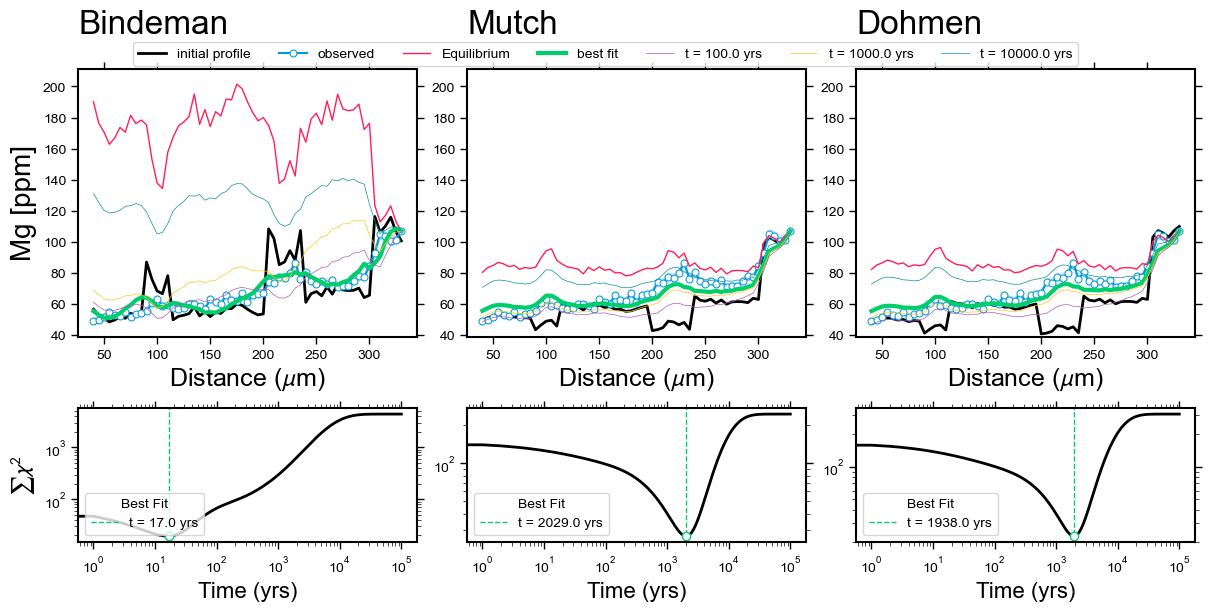

In [8]:
fig, ax = plt.subplots(2, 3, figsize=(12, 6), layout="constrained", height_ratios = [2,1])
axes = ax.ravel()
makeyears = 1
ms = 5
# #comparison curves. Omit this if you don't want them
compare = [makeyears*100,makeyears*1000,makeyears*10000]

for a,init_profile,eq_prof,curves,time,title in zip(axes[:3],initial_profiles,eq_profs, model_curves,model_bf_times,models):

    a.plot(dist, init_profile, "k-",marker = '', lw=2, label="initial profile")
    a.plot(dist, te, label="observed", c="C0", marker="o", mfc="w", mec="C0", mew=0.75,ms = ms)
    a.fill_between(dist, te + te_unc, te - te_unc, alpha=0.2)
    a.plot(dist, eq_prof, c="C1",marker = '', lw = 1, label="Equilibrium", ms = ms)  # boundary conditions
    a.plot(dist,curves[time],"-",c=bf_color,marker = '',mec="k",lw=3,label="best fit")


    compare_colors = ["C3", "C4", "C5"]
    for i in range(0, len(compare)):
        a.plot(
            dist,
            curves[compare[i]],
            marker = '',
            label="t = {} yrs".format(compare[i] / makeyears),
            lw=0.5,
            color = compare_colors[i]
        )
    
    
    a.set_title(title,fontsize = 24,y = 1.1)

    # a.set_ylim(np.array(eq_profs).min()*0.95,np.array(initial_profiles).max()*1.05)
    a.set_ylim(np.array(initial_profiles).min()*0.95,np.array(eq_profs).max()*1.05)
    a.set_xlabel('Distance ($\mu$m)')
    if a == axes[0]:
        a.set_ylabel(f"{element} [ppm]",fontsize = 20)
    
h,l = axes[0].get_legend_handles_labels()
fig.legend(h,l,loc = 'upper left',ncol = len(h), bbox_to_anchor = (0.1,.95))

for a, time, chi2 in zip(axes[3:],model_bf_times,model_chi2s):
    # chi-squared plot
    # convert to days
    tdays = t / (t[1] - t[0])
    x_data = tdays / makeyears
    a.plot(x_data, chi2, "-k", marker = '',lw=2,)
    # vertical line at best fit value
    a.axvline(time/makeyears,color=bf_color,label="t = {} yrs".format(np.round(time / makeyears, 2)),lw = 1, ls = '--')
    a.plot(x_data[time], chi2[time],mfc = 'w',marker = 'o',ls = '',mec = bf_color,mew = 1)
    a.set_xlabel("time (yrs)", fontsize=16)
    if a == axes[3]:

        a.set_ylabel("$\sum{\chi^2} $", fontsize=16)
    a.set_xscale("log")
    a.legend(loc="lower left", title = 'Best Fit',prop={"size": 10})
    a.set_yscale("log")
    a.set_xlabel('Time (yrs)')

# plt.savefig('{}\model_output_example.pdf'.format(export_path),bbox_inches = 'tight')


## Monte Carlo for model uncertainties

In [9]:
# set the limit to search for best time in each model
# to number of timesteps  in model above
limit = iterations
#number of models to run in Monte Carlo
n = 1000
monte_carlo_results = []
for i,name in zip(range(len(models)),models):

    print(f"Working on {name} model uncertainties")
    # run the Monte Carlo
    best_fits = plag.monte_carlo_fd(
        initial_profiles[i],
        te,
        te_unc,
        t,
        D,
        an_smooth,
        As[i]*1000,
        dist,
        T_K,
        n,
        limit,
        boundary="infinite observed",
        local_minima=False,
    )
    monte_carlo_results.append(best_fits)

Working on Bindeman model uncertainties


100%|██████████| 1000/1000 [00:00<00:00, 1416.49it/s]


Working on Mutch model uncertainties


100%|██████████| 1000/1000 [01:06<00:00, 15.03it/s]


Working on Dohmen model uncertainties


100%|██████████| 1000/1000 [01:07<00:00, 14.82it/s]


## Detailed Summary plot

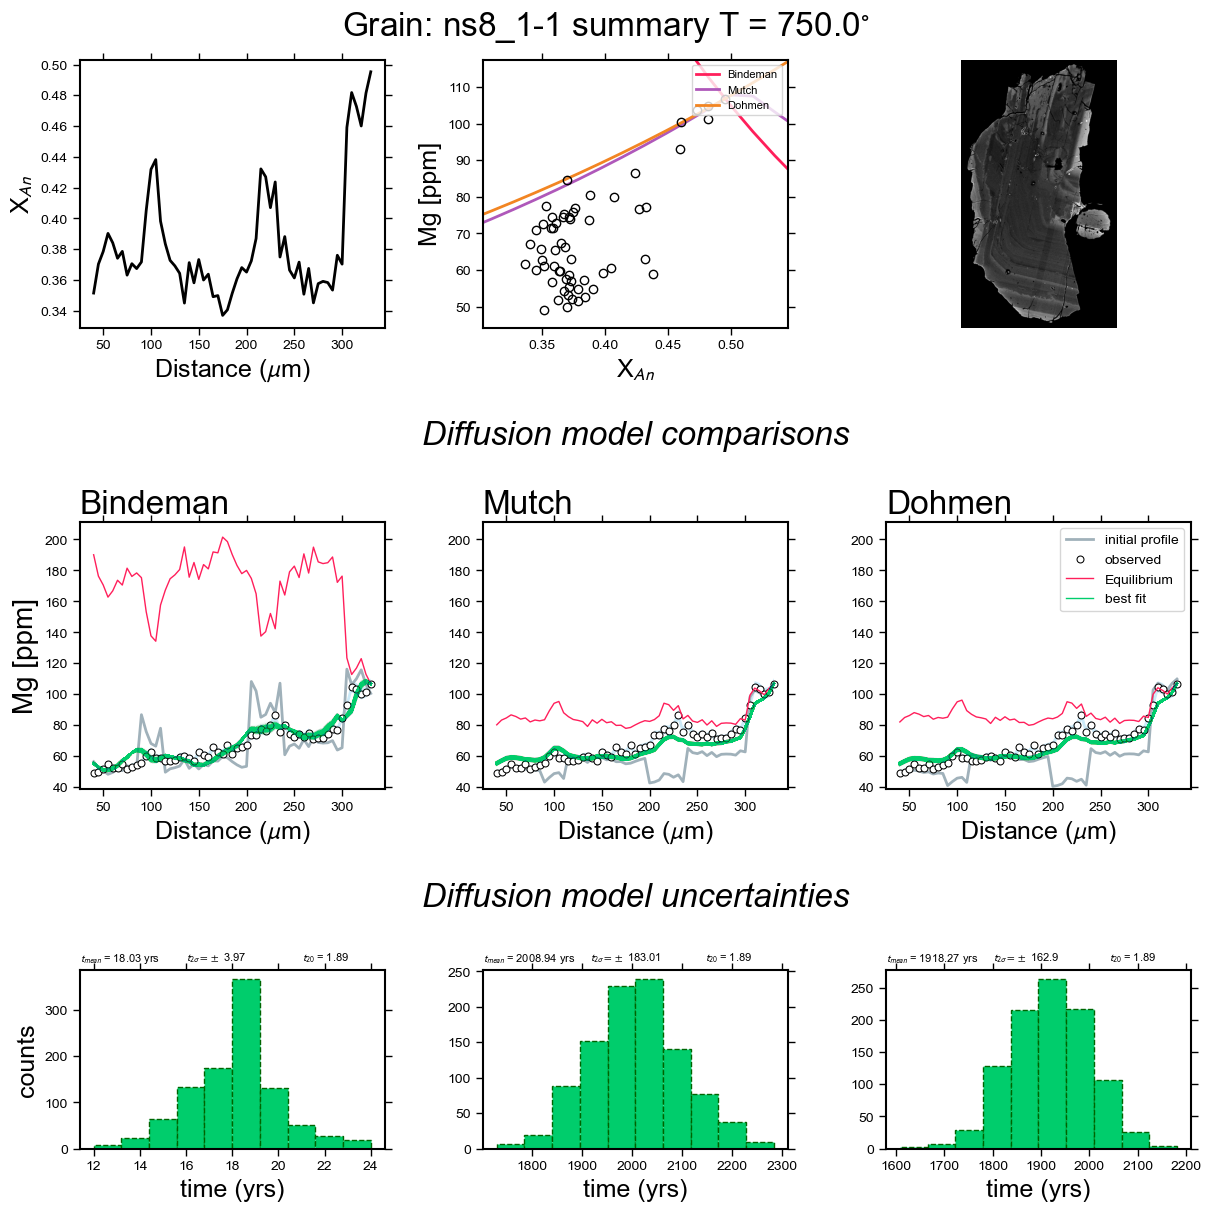

In [10]:
fig, ax = plt.subplot_mosaic(
        [
            ["an_prof","sr_an", "bse"],
            ["text_row1","text_row1","text_row1"],
            ["bind_model","niel_model","doh_model"],
            ["text_row2","text_row2","text_row2"],
            ["bind_hist","niel_hist","doh_hist"]
        ],
        figsize=(12,12),
        layout="constrained",
        height_ratios=[.3,.1,.3,.1,.2],
    )
ax["text_row1"].axis('off')
# Build a rectangle in axes coords
left, width = .25, .5
bottom, height = .25, .5
right = left + width
top = bottom + height
ax["text_row1"].text(0.5 * (left + right), 0.5 * (bottom + top), "Diffusion model comparisons",
        horizontalalignment='center',
        verticalalignment='center',
        transform=ax["text_row1"].transAxes,
        fontstyle = 'italic',
        fontsize = 24)

ax["text_row2"].axis('off')
ax["text_row2"].text(0.5 * (left + right), 0.5 * (bottom + top), "Diffusion model uncertainties",
        horizontalalignment='center',
        verticalalignment='center',
        transform=ax["text_row2"].transAxes,
        fontstyle = 'italic',
        fontsize = 24)

ax["an_prof"].plot(dist, an, "k-", marker = '',linewidth=2)
ax["an_prof"].set_ylabel("X$_{An}$")
ax["an_prof"].set_xlabel('Distance ($\mu$m)')


for method,cl,color in zip(models,cl_rims,[bindeman_color,mutch_color,dohmen_color]):
    if method == 'Mutch':
        
        kd_eq, rtlnk_eq, A_eq, x_an_dev_eq = plag.mutch_kd_calc(An_partition,T_K - 273.15, sio2_melt=sio2_melt)
    else:
        # Calculated Mg equilibrium
        kd_eq, rtlnk_eq, A_eq, B_eq = plag.plag_kd_calc(
            element, An_partition, T_K-273.15, method=method,sio2_melt = sio2_melt
    )
    Eq_solid_ave = cl * kd_eq
    ax["sr_an"].plot(An_partition,Eq_solid_ave,lw = 2,marker = '',color = color,label = method)
ax["sr_an"].plot(an, te,mec = obs_color,marker = 'o',ls = '',mfc = 'none',mew = 1)
ax["sr_an"].set_xlim(0.9*an.min(),1.1*an.max())
ax["sr_an"].set_ylim(0.9*te.min(),1.1*te.max())
ax["sr_an"].set_xlabel("X$_{An}$")
ax["sr_an"].set_ylabel(f"{element} [ppm]")
ax["sr_an"].legend(loc = 'upper right',ncol = 1,prop = {'size': 8})


# BSE of the plagioclase
for file in image_files:

    if grain in file:
        my_image = np.asarray(Image.open(file))
        

ax["bse"].imshow(my_image,cmap = 'binary_r')
ax["bse"].axis("off")

for a,init_profile,eq_prof,curves,time,title,result in zip(["bind_model","niel_model","doh_model"],initial_profiles,eq_profs, model_curves,model_bf_times,models,monte_carlo_results):

    ax[a].plot(dist, init_profile, init_color, marker = '',lw=2, label="initial profile")
    ax[a].plot(dist, te, label="observed", c=obs_color,ls = '', marker="o", mfc="w", mec=obs_color, mew=0.75,ms = ms)
    ax[a].fill_between(dist, te + te_unc, te - te_unc, alpha=0.2)
    ax[a].plot(dist, eq_prof, c="C1", lw = 1,marker = '', label="Equilibrium", ms = ms)  # boundary conditions
    # a.plot(dist,curves[time],"-",c=bf_color,mec="k",lw=3,label="best fit")
    
    ax[a].set_title(title,fontsize = 24,y = 1)
    # ax[a].set_ylim(np.array(eq_profs).min()*0.95,np.array(initial_profiles).max()*1.05)
    ax[a].set_ylim(np.array(initial_profiles).min()*0.95,np.array(eq_profs).max()*1.05)
    ax[a].set_xlabel('Distance ($\mu$m)')
    if a == "bind_model":
        ax[a].set_ylabel(f"{element} [ppm]",fontsize = 20)
    for fit in result:
        ax[a].plot(dist, curves[fit], c = bf_color,marker = '', ls = '-', lw = 2,alpha = .01,)

h,l = ax["doh_model"].get_legend_handles_labels()
bf_element = [Line2D([0], [0], color=bf_color, lw=1, label='best fit')]
ax["doh_model"].legend(handles = h+bf_element,loc = 'upper right')

fs = 8
monte_carlo_results = np.array(monte_carlo_results)
bin_vals= []
transform_means = []
transform_medians = []
transform_lows = []
transform_highs = []

for a, result in zip(["bind_hist","niel_hist","doh_hist"], monte_carlo_results):
    mc_results = result / makeyears
    counts, bins, patches = ax[a].hist(mc_results, facecolor=bf_color, edgecolor="darkgreen", linestyle="--",)
    ax[a].set_xlabel('time (yrs)')
    bin_vals.append(bins)
    if a == "bind_hist":
        ax[a].set_ylabel('counts')

    transform = None
    if transform:
        (
            transform_mc_results,
            transform_mean,
            transform_median,
            transform_low,
            transform_high,
        ) = plag.transform_data(mc_results, kind=transform)
        transform_means.append(transform_mean)
        transform_medians.append(transform_median)
        transform_lows.append(transform_low)
        transform_highs.append(transform_high)
        
        ax[a].text(
            0.0,
            1.05,
            "$t_{{mean}}$ = {} yrs".format(np.round(transform_mean, 2)),
            transform=ax[a].transAxes,
            fontsize=fs,
        )
        ax[a].text(
            0.35,
            1.05,
            "$t_{{2\sigma}} = \pm$ {} ; {}".format(
                np.round(transform_mean - transform_low, 2),
                np.round(transform_high - transform_mean, 2),
            ),
            transform=ax[a].transAxes,
            fontsize=fs,
        )
        
        ax[a].text(
            0.73,
            1.05,
            "$t_{{20}}$ = {}".format(np.round(t20.max(), 2)),
            transform=ax[a].transAxes,
            fontsize=fs,
        )


    else:
        ax[a].text(
            0.0,
            1.05,
            "$t_{{mean}}$ = {} yrs".format(np.round(mc_results.mean(), 2)),
            transform=ax[a].transAxes,
            fontsize=fs,
        )
        ax[a].text(
            0.35,
            1.05,
            "$t_{{2\sigma}} = \pm$ {}".format(np.round(2 * np.std(mc_results), 2)),
            transform=ax[a].transAxes,
            fontsize=fs,
        )
        
        ax[a].text(
            0.73,
            1.05,
            "$t_{{20}}$ = {} ".format(np.round(t20.max(), 2)),
            transform=ax[a].transAxes,
            fontsize=fs,
        )

# for a in ["bind_hist","niel_hist", "doh_hist"]:
#     ax[a].set_xlim(np.array(bin_vals).min(),np.array(bin_vals).max())
fig.suptitle(f"Grain: {grain} summary T = {T_K-273.15}$^{{\circ}}$")
fig.set_facecolor('w')
# plt.savefig(f"{export_path}/{grain}_{element}_diffresults_summary.pdf",bbox_inches = 'tight')
# plt.savefig(f"{export_path}/{grain}_{element}_diffresults_summary.png",bbox_inches = 'tight')

## Simple model summary plot
Just Dohmen and Blundy (2014) partitioning model results

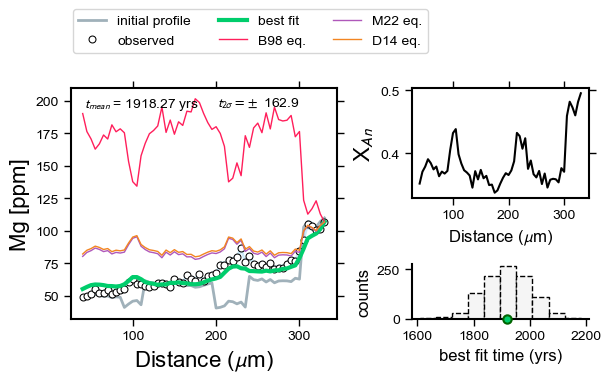

In [11]:
fig, ax = plt.subplot_mosaic(
    [["prof","an_prof"],
     ["prof","hist"]],layout = "constrained",
     height_ratios = [2,1],
     width_ratios = [3,2],
    figsize = (6,3)
)

ax["prof"].plot(dist, initial_profiles[2], init_color, marker = '',lw=2, label="initial profile")
ax["prof"].plot(dist, te, label="observed", c=obs_color,ls = '', marker="o", mfc="w", mec=obs_color, mew=0.75,ms = ms)
ax["prof"].fill_between(dist, te + te_unc, te - te_unc, alpha=0.2)
ax["prof"].plot(dist,curves[best_fits[2]],"-",c=bf_color,mec="k",lw=3,label="best fit")

for eq_prof,color,label in zip(eq_profs,[bindeman_color,mutch_color,dohmen_color],["B98","M22","D14"]):
    ax["prof"].plot(dist, eq_prof,marker = '', c=color, lw = 1, label = f"{label} eq.")  # boundary conditions


ax["prof"].set_xlabel('Distance ($\mu$m)',fontsize = 16)
ax["prof"].set_ylabel(f"{element} [ppm]",fontsize = 16)


fig.legend(loc = 'upper left',ncol = 3, bbox_to_anchor = (0.1,1.25))

ax["an_prof"].plot(dist, an, "k-", linewidth=1.5)
ax["an_prof"].set_ylabel("X$_{An}$",fontsize = 16)
ax["an_prof"].set_xlabel('Distance ($\mu$m)',fontsize = 12)

ax["hist"].hist(monte_carlo_results[2] / makeyears, facecolor="whitesmoke", edgecolor="k", linestyle="--",)
ax["hist"].plot(monte_carlo_results[2].mean() /makeyears,0,marker = 'o',mec = 'darkgreen',mfc = bf_color,mew = 1.5,clip_on=False,zorder = 10)
ax["hist"].set_xlabel("best fit time (yrs)",fontsize = 12)
ax["hist"].set_ylabel('counts',fontsize = 12)

ax["hist"].spines[['right', 'top']].set_visible(False)
ax["hist"].get_xaxis().tick_bottom()
ax["hist"].get_yaxis().tick_left()


if transform:
    ax["prof"].text(
           0.05,
        .92,
            "$t_{{mean}}$ = {} yrs".format(np.round(transform_mean, 2)),
            transform=ax["prof"].transAxes,
            fontsize=fs,
        )
    ax["prof"].text(
           0.55,
        .92,
            "$t_{{2\sigma}} = \pm$ {} ; {}".format(
                np.round(transform_mean - transform_low, 2),
                np.round(transform_high - transform_mean, 2),
            ),
            transform=ax["prof"].transAxes,
            fontsize=fs,
        )
else:

    ax["prof"].text(
        0.05,
        .92,
        "$t_{{mean}}$ = {} yrs".format(np.round(mc_results.mean(), 2)),
        transform=ax["prof"].transAxes,
        fontsize=10,
    )
    ax["prof"].text(
        0.55,
        .92,
        "$t_{{2\sigma}} = \pm$ {}".format(np.round(2 * np.std(mc_results), 2)),
        transform=ax["prof"].transAxes,
        fontsize=10,
    )
# plt.savefig(f"{export_path}/{grain}_{element}_manuscript_summary.pdf",bbox_inches = 'tight')


## Export model results

In [12]:
if transform:
    output_dict = {
        "grain": grain,
        "element": element,
        "resolution_um": resolution,
        "models": models,
        "best fit (yrs)": list(np.array(model_bf_times) / makeyears),
        "mc mean (yrs)": transform_means,
        "mc 2sig (yrs)": [transform_lows, transform_highs],
    }

else:
    output_dict = {
        "grain": grain,
        "element": element,
        "resolution_um": resolution,
        "models": models,
        "best fit (yrs)": list(np.array(model_bf_times) / makeyears),
        "mc mean (yrs)": list(monte_carlo_results.mean(axis=1) / makeyears),
        "mc 2sig (yrs)": list(monte_carlo_results.std(axis=1) / makeyears),
    }
pd.DataFrame([output_dict]).to_csv(
    "{}\{}_{}_model_summary.csv".format(export_path, grain, element), index=False
)